### csv to db

In [2]:

import csv
import sqlite3

# 데이터베이스에 연결
con = sqlite3.connect('main.db3')
cursor = con.cursor()

# 테이블 생성
cursor.execute('''
               drop table data
               ''')
cursor.execute('''
                CREATE TABLE data(
                InvoiceNo varchar(100),
                StockCode varchar(100),
                Description varchar(100),
                Quantity int,
                InvoiceDate date,
                UnitPrice float,
                CustomerID varchar(100),
                Country varchar(100)
                )''')

#csv 파일 읽기 및 데이터베이스에 삽입
with open('data.csv', 'r', encoding='latin1') as file:
    csv_data = csv.reader(file)
    next(csv_data) # 첫번째 행은 헤더이므로 건너뜀
    for row in csv_data:
        cursor.execute('INSERT INTO data VALUES (?, ?, ?, ?, ?, ?, ?, ?)', row)

#변경사항 저장 및 연결 종료
con.commit()
con.close()

## db 데이터 가져오기

In [121]:
import os
import datetime
# import squarify
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import plotly.graph_objs as go
# from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
# from lifetimes import BetaGeoFitter, GammaGammaFitter
# from lifetimes.plotting import plot_period_transactions
%matplotlib inline
# %load_ext nb_black
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

palette = 'Set2'

In [122]:
# db연결
conn = sqlite3.connect('main.db3')

# SQL 쿼리 실행 후 데이터 가져오기
query = "SELECT * FROM data"
df = pd.read_sql_query(query, conn, parse_dates = ['InvoiceDate'])

# 데이터 확인
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


데이터 확인

In [123]:
def check_data(df, head = 5):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    
    print(' Type '.center(70, '-'))
    print(df.dtypes)
    print(' HEAD '.center(70, '-'))
    print(df.head(head))
    print(' TAIL '.center(70, '-'))
    print(df.tail(head))
    
    print(' Missing Values '.center(70, '-'))
    print(df.isnull().sum())
    
    print(' Duplicated Values '.center(70, '-'))
    print(df.duplicated().sum())
    
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
-------------------------------- Type --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 0

World Map : 매출이 발생한 국가 시각화

In [124]:
!pip install plotly
!pip install nbformat
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px

# 고객Id, 송장, 국가 별로 그룹화 -> 각 그룹의 count 계산
world_map = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count().reset_index(drop=False)

# 그룹화 결과에서 '국가' 열 기반으로 국가의 주문수 계산
countries = world_map['Country'].value_counts()

data = dict(type = 'choropleth',           # 생성하려는 지도 종류(choropleth)
           locations = countries.index,    # 지도에 나타내는 지역 인덱스
           locationmode = 'country names',
           z = countries,
           text = countries.index,
           colorbar = {'title':'Orders'},  # 색상 막대의 제목
           colorscale = 'Viridis',
           reversescale = False)    # 색상 척도 반전 여부(false : 값이 커질 수록 진한 색상/true: 밝은색상)


layout = dict(title = {'text': "Number of Orders by Countries",
                      'y': 0.9,
                      'x' : 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
             geo = dict(resolution = 50,
                       showocean = True,
                       oceancolor = 'LightBlue',
                       showland = True,
                       landcolor = 'whitesmoke',
                       showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

기술 통계 : Descriptive Statistics

In [125]:
def desc_stats(df):
    desc_df = pd.DataFrame(index = df.columns,
                          columns = df.describe().T.columns,
                          data = df.describe().T)
    
    f, ax = plt.subplots(figsize = (10, desc_df.shape[0] * 0.81))
    
    sns.heatmap(desc_df, annot = True, cmap = 'Greens', fmt = '.2f', ax = ax, linecolor = 'white',
               linewidth = 1.1, cbar = False, annot_kws = {'size':12})
    plt.xticks(size = 18)
    plt.yticks(size = 14, rotation = 0)
    plt.title('Descriptive Statistics', size = 14)
    plt.show()


데이터 전처리 : Data Preprocessing - 이상치

In [126]:
def replace_with_thresholds(df, variable, q1 = 0.25, q3 = 0.75):
        
        df_ = df.copy()
        quartile1 = df_[variable].quantile(q1)
        quartile3 = df_[variable].quantile(q3)
        iqr = quartile3 - quartile1
        
        up_limit = quartile3 + 1.5 * iqr
        low_limit = quartile1 - 1.5 * iqr
        # 중요!! 'variable' 열의 값을 'low_limit'으로 대체
        df_.loc[(df_[variable] < low_limit), variable] = low_limit
        df_.loc[(df_[variable] > up_limit), variable] = up_limit
        
        return df_

데이터 전처리 - untiprice 음수값, 결측값

In [127]:
# 데이터 전처리 함수
def ecommerce_preprocess(df):
    df_ = df.copy()
    
    # 결측치 제거
    df_ = df_.dropna()
    
    # 취소된 주문과 주문량
    #  'InvoiceNo' 열에 'C' 문자열을 포함하는 행을 제거(nan값은 무시)
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    # 주문량이 0이 아닌 것만 필터링
    df_ = df_[df_['Quantity'] > 0]
    
    # 이상치 제거
    df_ = replace_with_thresholds(df_, 'Quantity', q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, 'UnitPrice', q1 = 0.01, q3 = 0.99)
    
    # 판매총액 컬럼 추가
    df_['TotalPrice'] = df_['Quantity'] * df_['UnitPrice']
    
    return df_

전처리 후 기술통계량

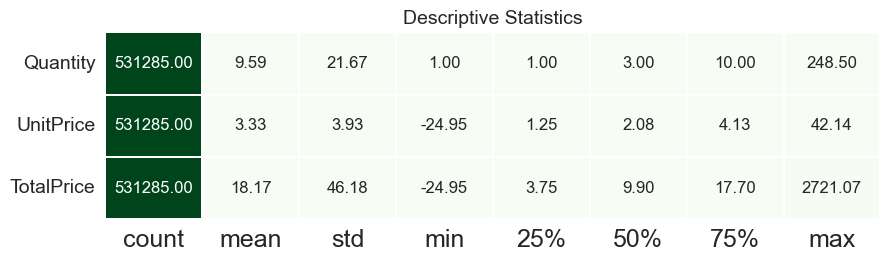

In [128]:
df = ecommerce_preprocess(df)
desc_stats(df.select_dtypes(include = [float, int]))

RFM metrics

In [129]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [130]:
import datetime as dt

# today_date 변수에는 2011년 12월 11일을 나타내는 datetime 객체가 저장
today_date = dt.datetime(2011, 12, 11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x : (today_date - x.max()).days,    #시간 간격을 일(day)로 표현:마지막 구매일로부터 지난 일수
                                   'InvoiceNo' : lambda x : x.nunique(),    # 총 몇 번 구매했는지
                                    'TotalPrice' : lambda x : x.sum()    # 총 누적 구매 금액
                                   })
rfm.columns = ['recency', 'frequency', 'monetary']

rfm = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

,CustomerID,recency,frequency,monetary
0,,1,2192,1520497.940
1,12346,326,1,258.440
2,12347,3,7,4310.000
3,12348,76,4,1797.240
4,12349,19,1,1499.685


RFM Scores

In [131]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)

rfm

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,,1,2192,1520497.940,5,5,5,55
1,12346,326,1,258.440,1,1,2,11
2,12347,3,7,4310.000,5,5,5,55
3,12348,76,4,1797.240,2,4,4,24
4,12349,19,1,1499.685,4,1,4,41
...,...,...,...,...,...,...,...,...
4334,18280,278,1,180.600,1,2,1,12
4335,18281,181,1,80.820,1,2,1,12
4336,18282,8,2,178.050,5,3,1,53
4337,18283,4,16,2094.880,5,5,5,55


Segmentation - 정규 표현식을 사용하여 RFM score를 바탕으로 고객의 그룹을 나눈다

In [132]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,,1,2192,1520497.940,5,5,5,55,champions
1,12346,326,1,258.440,1,1,2,11,hibernating
2,12347,3,7,4310.000,5,5,5,55,champions
3,12348,76,4,1797.240,2,4,4,24,at_Risk
4,12349,19,1,1499.685,4,1,4,41,promising


Segmentation Map

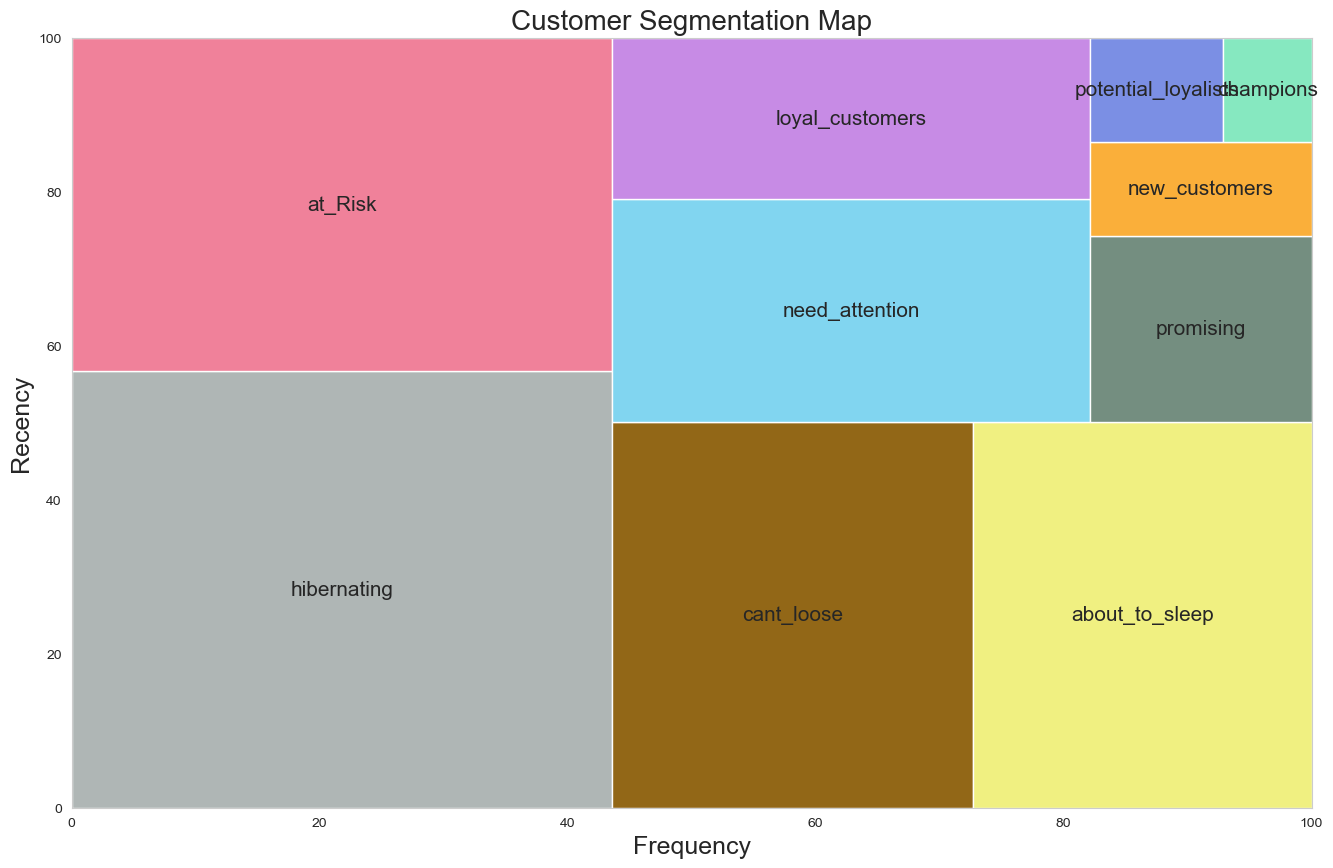

In [133]:
!pip install squarify
import squarify

segments = rfm['segment'].value_counts().sort_values(ascending = False)
segments

# figure 가져오기(캔버스)
fig = plt.gcf()
fig.set_size_inches(16, 10)

# fig에 서브플롯 추가(fig, add_suplot(2, 2, 1)처럼 쓰임)
ax = fig.add_subplot()

# 데이터를 트리맵(tree map) 형태로 시각화하는 데 사용
squarify.plot(sizes = segments,
             label = [label for label in seg_map.values()],
             color = ["#AFB6B5", "#F0819A","#926717","#F0F081","#81D5F0",
                        "#C78BE5","#748E80","#FAAF3A","#7B8FE4","#86E8C0"],
            pad = False,
            bar_kwargs = {'alpha': 1},
            text_kwargs = {'fontsize':15}       
            )

plt.title('Customer Segmentation Map', fontsize = 20)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Recency', fontsize = 18)
plt.show()

Segmentation Model Evaluation

In [134]:
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']

print(f'관측치 수 : {X.shape[0]}')
print(f'고객 세분화 수 : {labels.nunique()}')
print(f'실루엣 Score : {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
관측치 수 : 4339
고객 세분화 수 : 10
실루엣 Score : 0.471
Calinski Harabasz Score: 4591.018
Davies Bouldin Score: 0.633 


Segment Analysis

In [135]:
#  고객군 별 R, F, M 기술 통계 확인
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

recency                             monetary  \
                        min        std        mean  max      min   
segment                                                            
about_to_sleep           34  10.943474   53.312500   72     6.20   
at_Risk                  73  68.618828  153.785835  374    52.00   
cant_loose               73  65.250378  132.968254  373    70.02   
champions                 1   3.686545    6.353312   13   201.12   
hibernating              73  92.013560  217.605042  374     3.75   
loyal_customers          15  15.577050   33.608059   72    36.56   
need_attention           34  11.552074   52.427807   72     6.90   
new_customers             1   3.902112    7.428571   13    89.94   
potential_loyalists       1   9.338808   17.398760   33    20.80   
promising                15   5.192519   23.510638   33    30.00   

                                                            frequency  \
                              std         mean          max       min   
segment                                                                 
about_to_sleep         533.423294   469.189560     6207.670         1   
at_Risk                922.163586   934.461351    11072.670         2   
cant_loose            2002.884101  2631.978016    10254.180         6   
champions            62701.901258  8795.885505  1520497.940         3   
hibernating            551.924691   397.746608     9154.920         1   
loyal_customers       5311.812344  2738.886814   118632.240         3   
need_attention         734.037986   847.928824     4363.980         2   
new_customers          166.637402   312.163214      848.550         1   
potential_loyalists    600.179759   673.159804     4628.750         1   
promising              224.097767   286.188245     1499.685         1   

                                                 
                           std       mean   max  
segment                                          
about_to_sleep        0.368913   1.161932     2  
at_Risk               0.954415   2.878583     6  
cant_loose            4.289630   8.380952    34  
champions            88.113999  15.854890  2192  
hibernating           0.302492   1.101774     2  
loyal_customers       4.545669   6.479853    63  
need_attention        0.470081   2.326203     3  
new_customers         0.000000   1.000000     1  
potential_loyalists   0.651401   2.010331     3  
promising             0.000000   1.000000     1

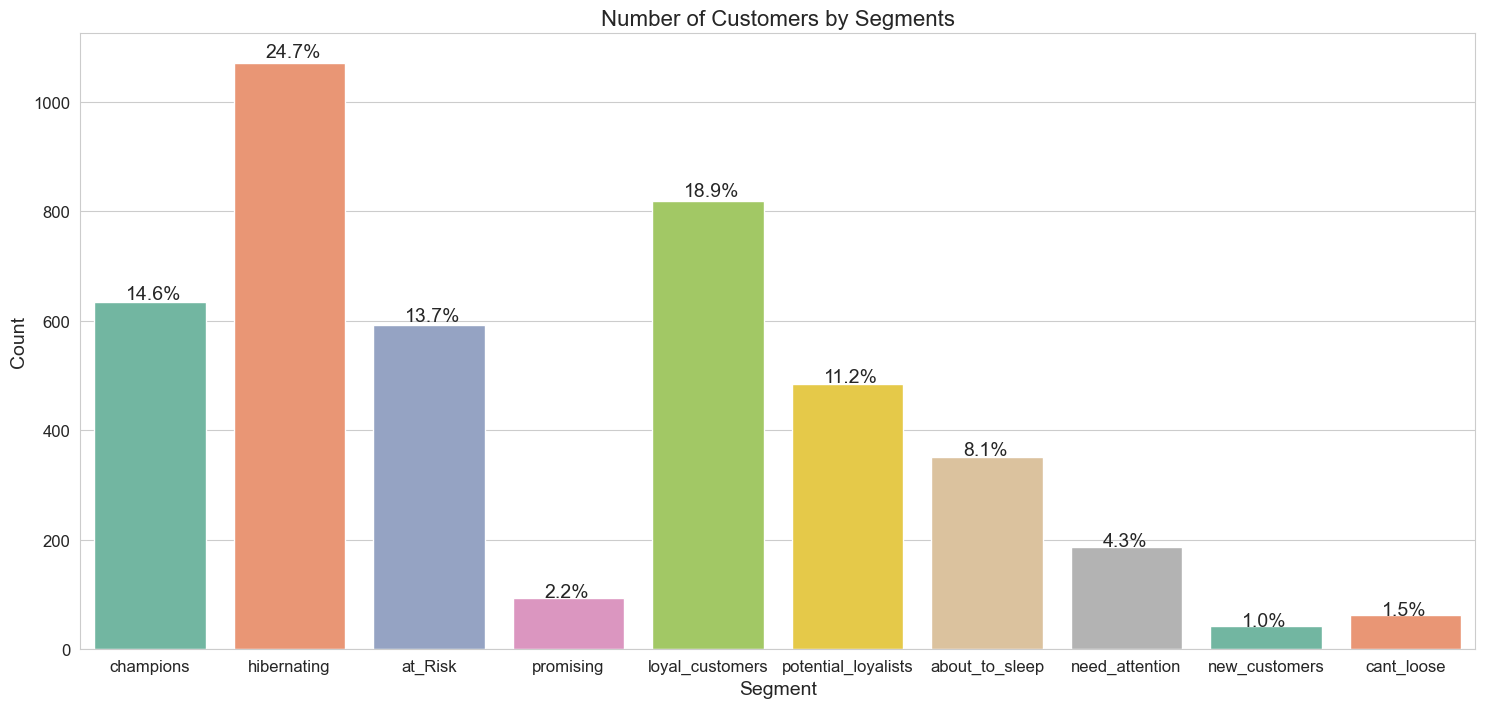

In [136]:
# 고객군 별 분포 시각화
plt.figure(figsize = (18, 8))
palette = 'Set2'

ax = sns.countplot(data = rfm,
                  x = 'segment',
                  palette = palette)

total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width()/2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.01
    ax.annotate(percentage, (x, y), size = 14)

plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

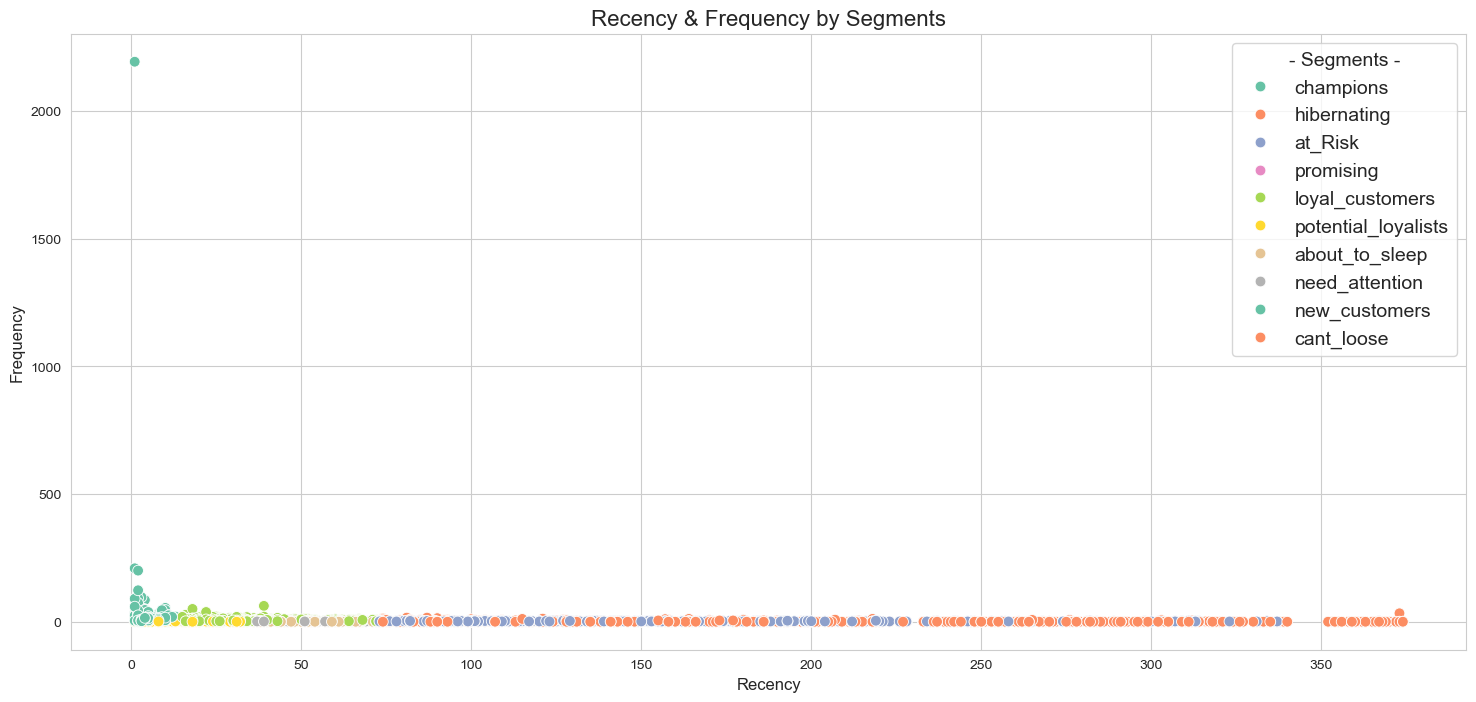

In [137]:
# 고객군 별 R,F 값 시각화
plt.figure(figsize = (18, 8))

sns.scatterplot(
    data = rfm, x = 'recency', y = 'frequency', hue = 'segment', palette = palette, s = 60)
plt.title('Recency & Frequency by Segments', size = 16)
plt.xlabel('Recency', size = 12)
plt.ylabel('Frequency', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.legend(loc = 'best', fontsize = 14, title = '- Segments -', title_fontsize = 14)
plt.show()

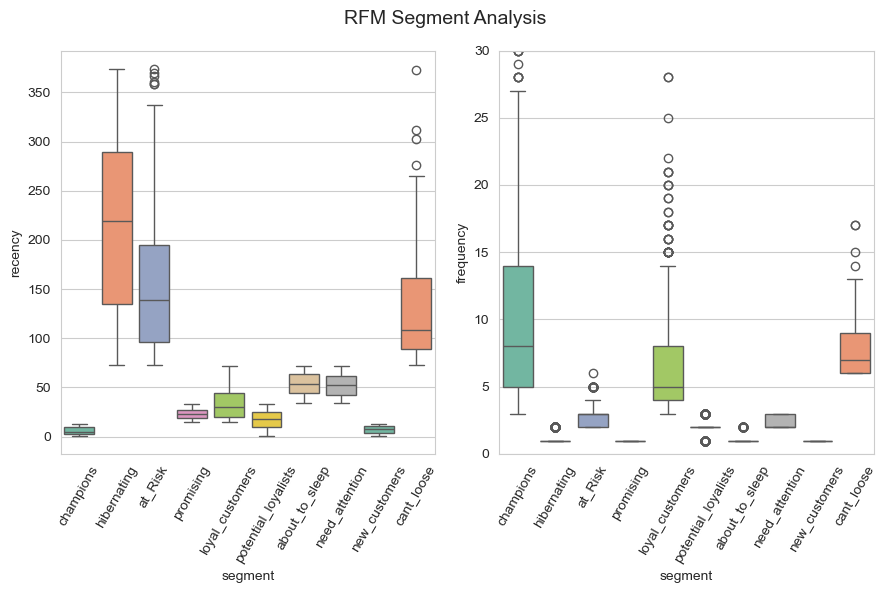

In [138]:
# 고객군 별 R,F 값 시각화(boxplot)
fig, axes = plt.subplots(1, 2, figsize = (9, 6))
fig.suptitle('RFM Segment Analysis', size = 14)

feature_list = ["recency", "frequency"]

for idx, col in enumerate(feature_list):
    sns.boxplot(ax = axes[idx], data = rfm, x = 'segment', y = feature_list[idx], palette = palette)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation = 60)
    
    if idx == 1:
        axes[idx].set_ylim([0, 30])

plt.tight_layout()
plt.show()

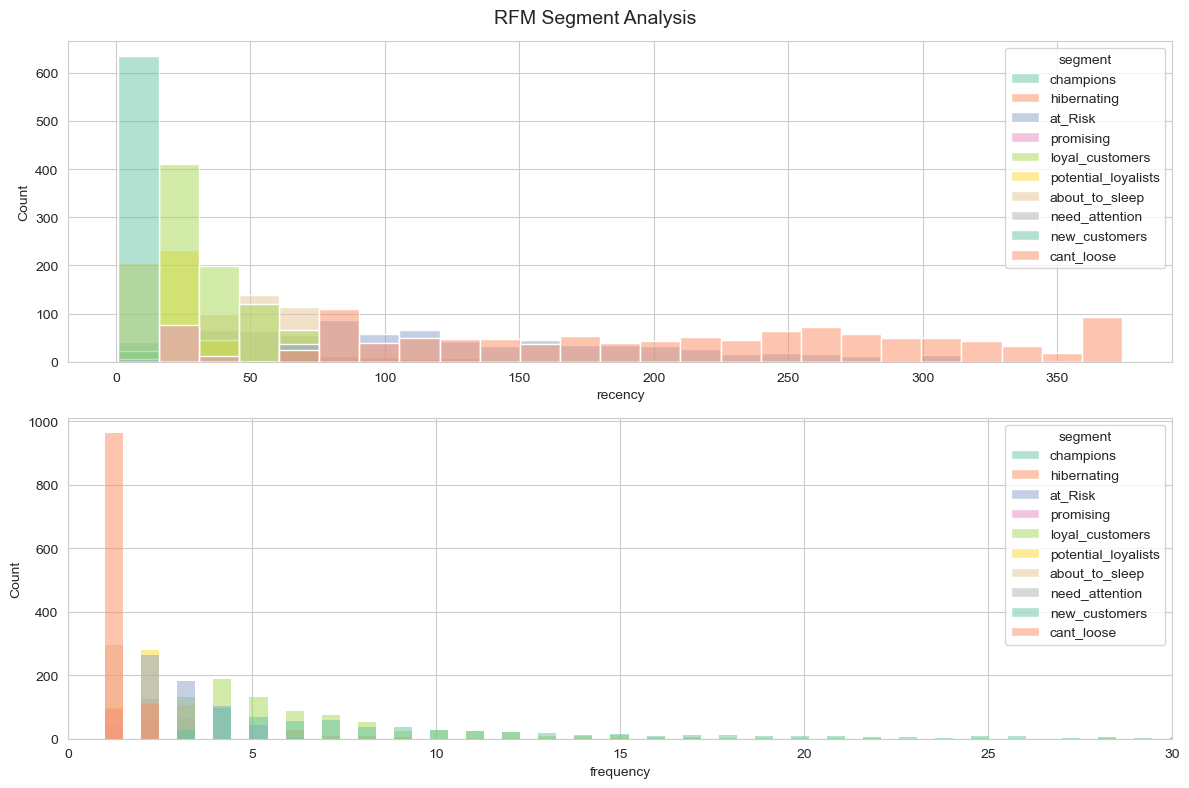

In [139]:
# 고객군 별 R,F 값 시각화(histplot)
fig, axes = plt.subplots(2, 1, figsize = (12, 8))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['recency', 'frequency']

for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm, x = feature_list[idx], hue = 'segment', palette=palette)
    
    if idx == 1:
        axes[idx].set_xlim([0, 30])


plt.tight_layout()
plt.show()

Cohort Analysis
 - 코호트는 어떤 공통점을 공유하는 사람들의 그룹을 의미
 - 코호트 분석에서는 이러한 사용자 그룹을 시간에 따라 추적하여 일반적인 패턴이나 행동을 식별하기 위해 사용

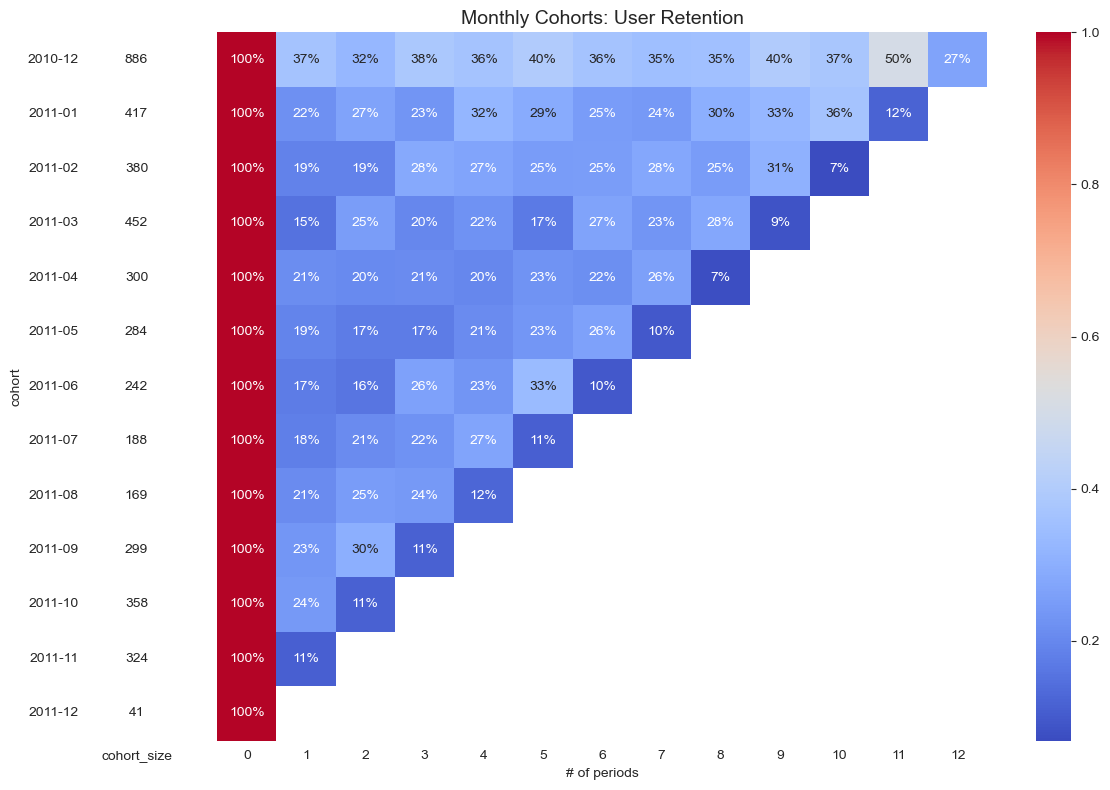

In [140]:
# cohort(최초 주문일과 고객 당 주문 건의 날짜 추출)
def CohortAnalysis(dataframe):
    
    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    
    data['order_month'] = data['InvoiceDate'].dt.to_period('M')
    data['cohort'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
    cohort_data = (
        data.groupby(['cohort', 'order_month']).agg(n_customers = ('CustomerID', 'nunique'))\
            .reset_index(drop = False)
    )
    
    # 최초 주문일과 주문 건별 일수 차이 계산
    cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort).apply(attrgetter('n'))
    
    # pivot_table 로 코호트(최초 구매일) 기준, 경과 시간 별 구매 고객 수 계산
    cohort_pivot = cohort_data.pivot_table(
        index = 'cohort', columns = 'period_number', values = 'n_customers'
    )

    # 코호트 초기 고객수
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # 고객 유지율 계산
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    # 고객 유지율 시각화(heatmap)
    with sns.axes_style('white'):     # 배경을 흰색으로 설정
        
        fig, ax = plt.subplots(
                    1, 2, figsize = (12, 8), sharey = True, gridspec_kw = {'width_ratios':[0.1, 1]}
                    )
        
        sns.heatmap(retention_matrix,
                    mask = retention_matrix.isnull(),
                    annot = True,
                    cbar = True,
                    fmt = '.0%',
                    cmap = 'coolwarm',
                    ax = ax[1])
        
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel='# of periods', ylabel = " ")
        
        white_cmap = mcolors.ListedColormap(['white'])
        
        sns.heatmap(pd.DataFrame(cohort_size).rename(columns = {0:'cohort_size'}),
                   annot = True, cbar = False, fmt = 'g', cmap = white_cmap, ax = ax[0])

    fig.tight_layout()

CohortAnalysis(df)

In [141]:

cltv_df = df.groupby('CustomerID').agg(
        {'InvoiceDate' : [lambda x : (x.max() - x.min()).days,     #고객별 구매기간
                          lambda x : (today_date - x.min()).days], #고객별 최초 구매로부터 현재까지의 시간
        'InvoiceNo' : 'nunique',  #몇 번 주문했는지
         'TotalPrice' : 'sum'     #얼마나 많은 돈을 썼는지
        })

# 열 이름에 있는 다중 레벨 인덱스에서 최상위 레벨의 레벨을 제거
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df

,recency,T,frequency,monetary
CustomerID,,,,
,372,374,2192,1520497.940
12346,0,326,1,258.440
12347,365,368,7,4310.000
12348,282,359,4,1797.240
12349,0,19,1,1499.685
...,...,...,...,...
18280,0,278,1,180.600
18281,0,181,1,80.820
18282,118,127,2,178.050


Customer Lifetime Value

In [142]:
# 평균 주문 금액(구매 건당)
cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']

# 구매 기간을 주 단위로 변경(weeks)
cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['T'] = cltv_df['T'] / 7

# 재구매한 고객(2번 이상 구매한 고객)만 추출
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df

,recency,T,frequency,monetary
CustomerID,,,,
,53.142857,53.428571,2192,693.657819
12347,52.142857,52.571429,7,615.714286
12348,40.285714,51.285714,4,449.310000
12352,37.142857,42.428571,8,224.018125
12356,43.142857,46.571429,3,937.143333
...,...,...,...,...
18272,34.857143,35.285714,6,513.096667
18273,36.428571,36.857143,3,68.000000
18282,16.857143,18.142857,2,89.025000


BN/NBD

In [146]:
!pip install lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
# %matplotlib inline
# %load_ext nb_black

BGF = BetaGeoFitter(penalizer_coef=0.001)   #과적합 방지
BGF.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2846 subjects, a: 0.12, alpha: 7.18, b: 2.53, r: 1.55>

예측 1.  가장 많은 거래를 할 것으로 예상되는 고객(1주일 기준)

In [159]:
bgf_1w = BGF.conditional_expected_number_of_purchases_up_to_time( \
    1, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) \
    .sort_values(ascending = False).head(10).to_frame(
    "Expected Number of Transactions").reset_index()
    
bgf_1w

,CustomerID,Expected Number of Transactions
0,,12.878279
1,12748,3.481335
2,14911,3.333222
3,17841,2.064394
4,13089,1.634493
5,14606,1.555222
6,15311,1.522912
7,12971,1.440642
8,14646,1.300458
9,13408,1.044246


db에 저장

In [154]:
bgf_1w = bgf_1w.drop(index=0)

bgf_1w.to_sql('bgf_1w', conn, if_exists='replace', index=False)

9

예측 2.  가장 많은 거래를 할 것으로 예상되는 고객(1 개월 기준)

In [157]:
bgf_1m = BGF.conditional_expected_number_of_purchases_up_to_time(
    4, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) \
    .sort_values(ascending = False).head(10).to_frame(
    "Expected Number of Transactions").reset_index()
    
bgf_1m

,CustomerID,Expected Number of Transactions
0,,51.358449
1,12748,13.883547
2,14911,13.292876
3,17841,8.232803
4,13089,6.518181
5,14606,6.202231
6,15311,6.073377
7,12971,5.745248
8,14646,5.185526
9,13408,4.164461


db에 저장

In [156]:
bgf_1m = bgf_1m.drop(index=0)

bgf_1m.to_sql('bgf_1m', conn, if_exists='replace', index=False)

9

예측 3.  주어진 기간 내 실제 거래 빈도와 예측된 거래 빈도를 시각화
 - max_frequency=7: 이 부분은 그래프에서 표시할 최대 주기를 설정 -> 7일 주기

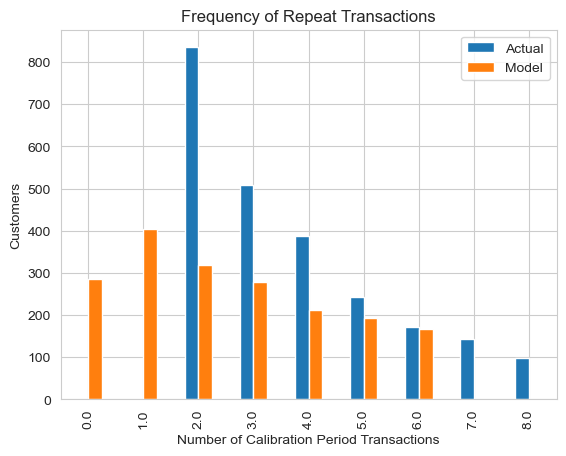

In [149]:
plot_period_transactions(BGF, max_frequency=7)
plt.show()

In [5]:
import pandas as pd
# db연결
conn = sqlite3.connect('main.db3')

# SQL 쿼리 실행 후 데이터 가져오기
query = "SELECT * FROM bgf_1w"
df = pd.read_sql_query(query, conn)

# 데이터 확인
df.info()
df.describe()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CustomerID                       9 non-null      object 
 1   Expected Number of Transactions  9 non-null      float64
dtypes: float64(1), object(1)
memory usage: 272.0+ bytes


,CustomerID,Expected Number of Transactions
0,12748,3.481335
1,14911,3.333222
2,17841,2.064394
3,13089,1.634493
4,14606,1.555222
5,15311,1.522912
6,12971,1.440642
7,14646,1.300458
8,13408,1.044246
